In [1]:
import os
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb



In [17]:
import os
import pandas as pd
import numpy as np



train = pd.read_csv("ch08_안전운전예측/train.csv", index_col="id")
test = pd.read_csv("ch08_안전운전예측/test.csv", index_col="id")

print(train.shape, test.shape)


(595212, 58) (892816, 57)


In [34]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target',axis=1)
all_features = all_data.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [19]:
# -1을 결측치로 처리
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)

# target 제외한 numeric 컬럼만 결측치 처리
numeric_cols = [col for col in train.columns if col != 'target']

for col in numeric_cols:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    
    if col in test.columns:  # test에 있을 때만 채우기
        test[col] = test[col].fillna(med)



In [20]:
def remove_outlier_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# target 상관 높은 변수 기반으로 outlier 제거 적용
important_cols = ["ps_car_13", "ps_reg_03", "ps_ind_15"]

for col in important_cols:
    train = remove_outlier_iqr(train, col)


In [25]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X = train.drop("target", axis=1)
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
#xgboost 모델 학습
import xgboost as xgb

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.03,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_estimators": 500,
    "tree_method": "hist",     # 빠르게
    "n_jobs": -1,
}

model = xgb.XGBClassifier(**params)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
# 성능 평가((Accuracy / Precision / Recall / ROC-AUC))
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

valid_pred_prob = model.predict_proba(X_test)[:, 1]
valid_pred = (valid_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, valid_pred)
prec = precision_score(y_test, valid_pred)
rec = recall_score(y_test, valid_pred)
auc = roc_auc_score(y_test, valid_pred_prob)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("ROC-AUC  :", auc)


Accuracy : 0.9657794676806084
Precision: 0.0
Recall   : 0.0
ROC-AUC  : 0.6264801490330949


c:\Users\Admin\miniconda3\envs\eda_env2\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [28]:
final_model = xgb.XGBClassifier(**params)
final_model.fit(X, y)

test_pred = final_model.predict_proba(test)[:, 1]

submission = pd.DataFrame({
    "id": test.index,
    "target": test_pred
})

submission.to_csv("submission.csv")
print("Saved : submission.csv")


Saved : submission.csv


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8776\2867805405.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train["target"], palette="Blues")


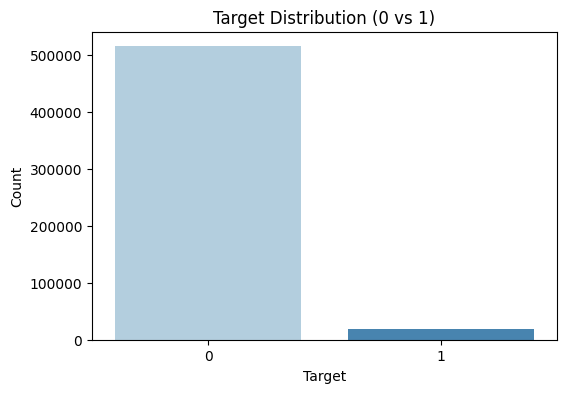

In [29]:
# Target분포
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=train["target"], palette="Blues")
plt.title("Target Distribution (0 vs 1)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8776\3653211153.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x="target", y="ps_car_13", palette="Pastel1")


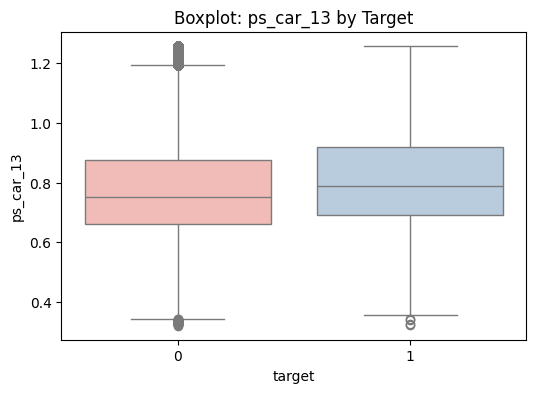

In [30]:
# 이상치를 제거한 이유
# feature 분포
plt.figure(figsize=(6,4))
sns.boxplot(data=train, x="target", y="ps_car_13", palette="Pastel1")
plt.title("Boxplot: ps_car_13 by Target")
plt.show()


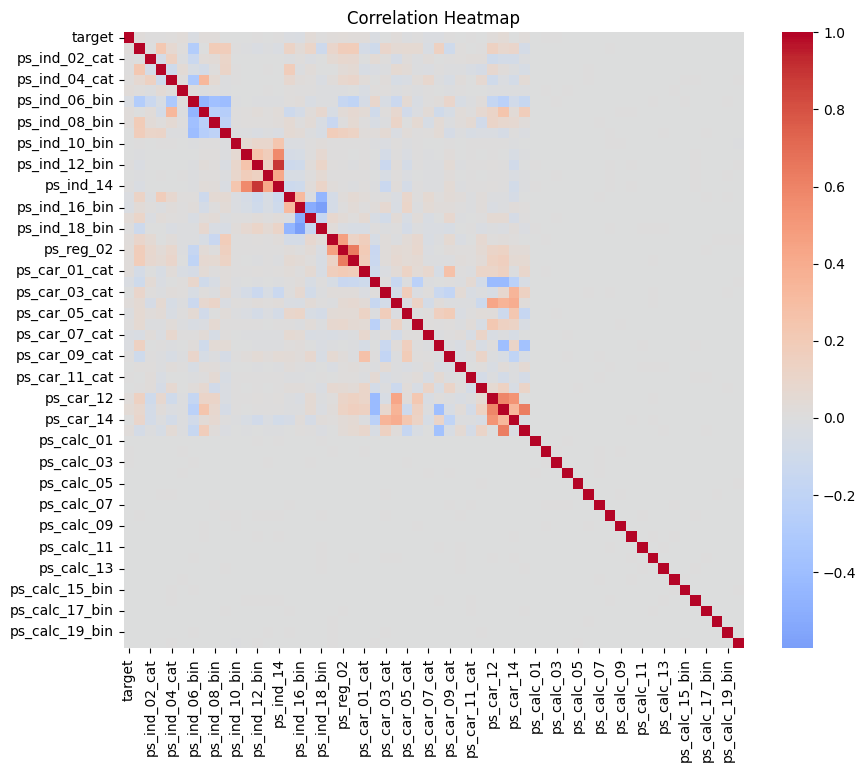

In [31]:
# 상관관계 Heatmap
import numpy as np

corr = train.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


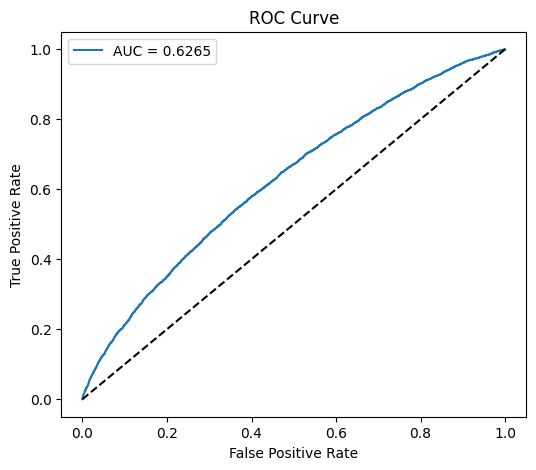

In [32]:
# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

valid_pred_prob = model.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, valid_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_valid, valid_pred_prob):.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


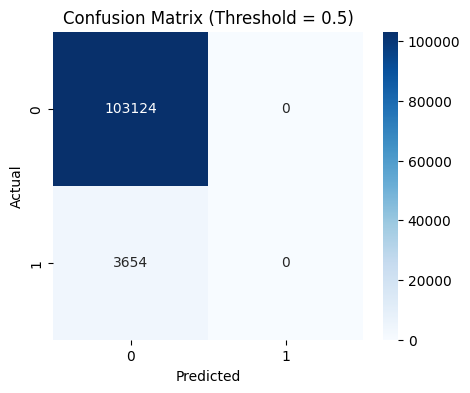

In [33]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

valid_pred = (valid_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_valid, valid_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 800x600 with 0 Axes>

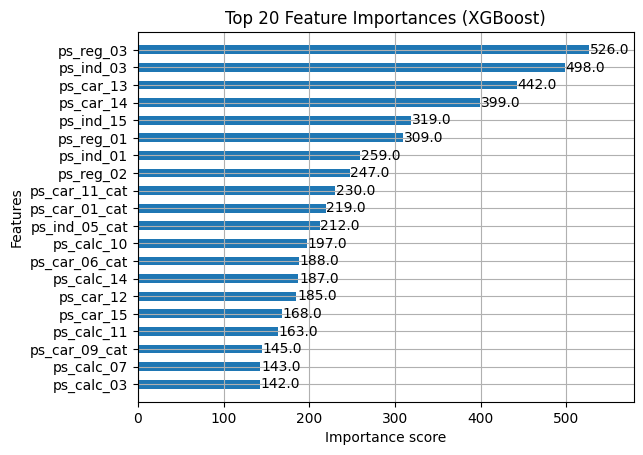

In [35]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(8, 6))
plot_importance(model, max_num_features=20, height=0.5)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()
